In [2]:
import re
import torch
from PIL import Image
import matplotlib.pyplot as plt
import gc
import requests
import copy
from PIL import Image
from io import BytesIO
from torch.nn.functional import mse_loss
import numpy as np
import einops
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model
from llava.conversation import conv_templates
from llava.constants import (
    IMAGE_TOKEN_INDEX,
    DEFAULT_IMAGE_TOKEN,
    DEFAULT_IM_START_TOKEN,
    DEFAULT_IM_END_TOKEN,
    IMAGE_PLACEHOLDER,
)
from llava.mm_utils import (
    process_images,
    tokenizer_image_token,
    get_model_name_from_path,
)

from utils.models.factory import create_model_and_transforms, get_tokenizer
from utils.models.prs_hook import hook_prs_logger
from utils.scripts.utils_llava import *

/cluster/apps/vogtlab/users/vstrozzi/software/anaconda/envs/MT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Could not find the bitsandbytes CUDA binary at PosixPath('/cluster/apps/vogtlab/users/vstrozzi/software/anaconda/envs/MT/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda121.so')
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.


[2025-03-04 17:29:15,932] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
## Parameters
device = 'cuda'
seed = 0
num_last_layers_ = 4
subset_dim = 10
tot_samples_per_class = 50
dataset_text_name = "top_1500_nouns_5_sentences_imagenet_clean"
datataset_image_name = "imagenet"
cache_dir = "../cache"

In [4]:
# Helper functions
def image_parser(image_file, sep=","):
    out = image_file.split(sep)
    return out


def load_image(image_file):
    if image_file.startswith("http") or image_file.startswith("https"):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image


def load_images(image_files):
    out = []
    for image_file in image_files:
        image = load_image(image_file)
        out.append(image)
    return out

device = "cuda"
model_name = "liuhaotian/llava-v1.5-7b"
model_path = "/cluster/work/vogtlab/Group/vstrozzi/cache/models--liuhaotian--llava-v1.5-7b/snapshots/4481d270cc22fd5c4d1bb5df129622006ccd9234/"

## Get LLava Model

In [5]:
### IMPORT: On Biomedcluster change .config under model_path to point towards correct vision_tower clip path
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,
    model_name=get_model_name_from_path(model_name),
)
model.to("cpu")

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]/cluster/apps/vogtlab/users/vstrozzi/software/anaconda/envs/MT/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 2/2 [00:09<00:00,  4.65s/it]


LlavaLlamaForCausalLM(
  (model): LlavaLlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaR

In [6]:
# CLIP model
model_CLIP_name = 'ViT-L-14-336' 
pretrained = "openai"
precision = "fp16"

torch.cuda.empty_cache()
model_CLIP, _, preprocess_clip = create_model_and_transforms(model_CLIP_name, pretrained=pretrained, precision=precision, cache_dir="../cache")

model_CLIP.eval()
context_length = model_CLIP.context_length
# Not needed anymore
vocab_size = model_CLIP.vocab_size
tokenizer_CLIP = get_tokenizer(model_CLIP_name)


print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model_CLIP.visual.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)
print("Len of res:", len(model_CLIP.visual.transformer.resblocks))
# Hook necessary to have: no projection on shared space, no spatial tokens in output (i.e. contributuon of attention to tokens), and hidden outputs of all tokens
prs = hook_prs_logger(model_CLIP, device, spatial=False, vision_projection=False, full_output=True) # This attach hook to get the residual stream


final_embeddings_images = torch.tensor(np.load(f"output_dir/{datataset_image_name}_embeddings_{model_CLIP_name}_seed_{seed}.npy", mmap_mode="r")).to(device)
final_embeddings_texts = torch.tensor(np.load(f"output_dir/{dataset_text_name}_{model_CLIP_name}.npy", mmap_mode="r")).to(device)

Model parameters: 304,293,888
Context length: 77
Vocab size: 49408
Len of res: 24


## Project a CLIP text embedding into hidden space of ViT Encoder

In [8]:
P = retrieve_proj_matrix(model_CLIP).to(device)

ln_weight, ln_bias, ln_eps = retrieve_post_layer_norm_par(model_CLIP)
ln_weight, ln_bias, ln_eps = ln_weight.to(device), ln_bias.to(device), ln_eps

In [33]:
model_CLIP.to("cuda")

# Get an image and a query text
with torch.no_grad():
    prs.reinit()
    model_CLIP.eval()
    # If querying by text, define a text prompt and encode it into an embedding
    text_query = "cat."
    # Tokenize the text query and move it to the device (GPU/CPU)
    text_query_token = tokenizer_CLIP(text_query).to(device)  
    # Encode the tokenized text into a normalized embedding
    topic_emb = model_CLIP.encode_text(text_query_token, normalize=False)
    # If querying by image, load and preprocess the image from disk
    prs.reinit()  # Reinitialize any hooks if required
    text_query = "woman.png"
    image_pil = Image.open(f'images/{text_query}')
    image = preprocess_clip(image_pil)[np.newaxis, :, :, :]  # Add batch dimension
    if precision == "fp16":
        image = image.to(dtype=torch.float16)
        topic_emb = topic_emb.to(dtype=torch.float16)
        

    # Encode the image into a normalized embedding
    image_emb = model_CLIP.encode_image(
        image.to(device), 
        attn_method='head_no_spatial',
        normalize=False
    )
    print(image_emb.shape)
    print(topic_emb.shape)
# Center text embed on image embed
mean_final_images = torch.mean(final_embeddings_images, axis=0)
mean_final_texts = torch.mean(final_embeddings_texts, axis=0)

if precision == "fp16":
    mean_final_images = mean_final_images.to(dtype=torch.float16)
    mean_final_texts = mean_final_texts.to(dtype=torch.float16)

topic_emb = topic_emb - mean_final_texts + mean_final_images

print("Normal")
print(topic_emb.norm())
print(image_emb.norm())
print(topic_emb @ image_emb.T)

# Project 
def remove(a, b):
    a = a.squeeze()
    b = b.squeeze()
    return (a - (torch.dot(a, b) / torch.dot(b, b)) * b).unsqueeze(0)
# Fictious values
mean = torch.tensor(0.15)
std = torch.tensor(1)

invert_topic_emb = invert_proj_layer_norm(topic_emb, P, ln_weight, ln_bias, std, mean, ln_eps)
invert_image_emb = remove(invert_proj_layer_norm(image_emb, P, ln_weight, ln_bias, std, mean, ln_eps), invert_topic_emb)

print("After proj back")
print(invert_topic_emb.norm())
print(invert_image_emb.norm())
print(invert_topic_emb @ invert_image_emb.T)

# Go back and revaluate
topic_emb_p = model_CLIP.visual.ln_post(invert_topic_emb) @ P
image_emb_p = model_CLIP.visual.ln_post(invert_image_emb) @ P
print(invert_topic_emb.shape)
print("Normal proj back")
print(topic_emb_p.norm())
print(image_emb_p.norm())
print(torch.norm(topic_emb_p - image_emb_p))
print(topic_emb_p @ image_emb_p.T)

torch.Size([1, 768])
torch.Size([1, 768])
Normal
tensor(15.6875, device='cuda:0', dtype=torch.float16)
tensor(18.7500, device='cuda:0', dtype=torch.float16)
tensor([[25.4844]], device='cuda:0', dtype=torch.float16)
After proj back
tensor(254.1250, device='cuda:0', dtype=torch.float16)
tensor(30.7344, device='cuda:0', dtype=torch.float16)
tensor([[0.0637]], device='cuda:0', dtype=torch.float16)
torch.Size([1, 1024])
Normal proj back
tensor(4.6680, device='cuda:0', dtype=torch.float16,
       grad_fn=<LinalgVectorNormBackward0>)
tensor(19.4062, device='cuda:0', dtype=torch.float16,
       grad_fn=<LinalgVectorNormBackward0>)
tensor(18.1562, device='cuda:0', dtype=torch.float16,
       grad_fn=<LinalgVectorNormBackward0>)
tensor([[34.2812]], device='cuda:0', dtype=torch.float16,
       grad_fn=<MmBackward0>)


## Here play around with LLava

In [24]:
# Mean ablate head at some lyers using contribution of all elements in batch and spatial
def mean_ablate_head(attentions, mlps, select_layer, layers=None, heads=None):
    # [b, l, h, n, d], [b, l + 1, n, d]

    # Perform mean ablation on used layers and tokens!
    mean_ablation_all = attentions[:, :(select_layer + 1), :, 1:, :].mean(dim=(0, 1, 2, 3))
    if heads != None and layers != None:
        for layer, head in zip(layers, heads):        
            attentions[:, layer, head, :, :] = mean_ablation_all

    return attentions[:, :(select_layer + 1), :, 1:, :].sum(1).sum(1) + mlps[:, :(select_layer + 1), 1:, :].sum(1)

# Project 
def remove(a, b):
    a = a.squeeze()
    b = b.squeeze()
    return (a - (torch.dot(a, b) / torch.dot(b, b)) * b).unsqueeze(0)

def remove_patches(p, b):
    p = p.squeeze()
    for i in range(p.shape[0]):
        p[i:i+1, :] = remove(p[i:i+1, :], b)

    return p.unsqueeze(0)

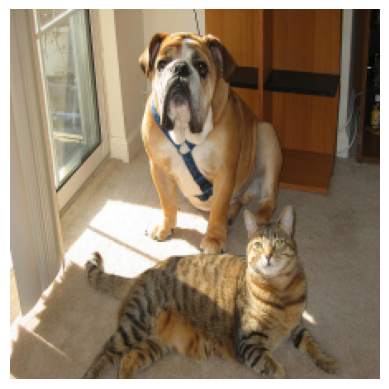

A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Describe the image focusing on main subjects. ASSISTANT:
torch.Size([1, 24, 16, 577, 1024])


/cluster/apps/vogtlab/users/vstrozzi/software/anaconda/envs/MT/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/cluster/apps/vogtlab/users/vstrozzi/software/anaconda/envs/MT/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `None` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


The image features a cat sitting on a couch, with a dog standing nearby. The cat is positioned on the left side of the couch, while the dog is on the right side. The dog appears to be a bulldog, and the cat is a tabby. The scene takes place in a living room, with a TV in the background.


In [27]:
# Layer where to extract infos on patches
select_layer = -2
# Params
prompt = "Describe the image focusing on main subjects."
image_file = "images/catdog.png"
max_new_tokens = 512
num_beams = 1 # numer of path of decision, less faster
sep =  ","
temperature = 0 # 0 lowest, det
top_p = None
images_embeds = True # If provided image embeds

## Visualize image
img = Image.open(image_file)
plt.imshow(img)
plt.axis('off')  # Hide axis ticks and labels
plt.show()
## Tokenization prompt
image_token_se = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN
# Making prompt in correct format
if IMAGE_PLACEHOLDER in prompt:
    if model.config.mm_use_im_start_end:
        prompt = re.sub(IMAGE_PLACEHOLDER, image_token_se, prompt)
    else:
        prompt = re.sub(IMAGE_PLACEHOLDER, DEFAULT_IMAGE_TOKEN, prompt)
else:
    if model.config.mm_use_im_start_end:
        prompt = image_token_se + "\n" + prompt
    else:
        prompt = DEFAULT_IMAGE_TOKEN + "\n" + prompt

## Convert model
if "llama-2" in model_name.lower():
    conv_mode = "llava_llama_2"
elif "mistral" in model_name.lower():
    conv_mode = "mistral_instruct"
elif "v1.6-34b" in model_name.lower():
    conv_mode = "chatml_direct"
elif "v1" in model_name.lower():
    conv_mode = "llava_v1"
elif "mpt" in model_name.lower():
    conv_mode = "mpt"
else:
    conv_mode = "llava_v0"

if conv_mode is not None and conv_mode != conv_mode:
    print(
        "[WARNING] the auto inferred conversation mode is {}, while `--conv-mode` is {}, using {}".format(
            conv_mode, conv_mode, conv_mode
        )
    )
else:
    conv_mode = conv_mode

## Load conversation mode standard template 
conv = conv_templates[conv_mode].copy()
conv.append_message(conv.roles[0], prompt)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()
print(prompt)

## Load images from online or local
image_files = image_parser(image_file, sep)
images = load_images(image_files)
image_sizes = [x.size for x in images]
images_tensor = process_images(
    images,
    image_processor,
    model.config
).to(model.device, dtype=torch.float16)


## Tokenize prompt
input_ids = (
    tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
    .unsqueeze(0)
    .to(device)
)


## Use CLIP Model
if images_embeds:
    prs.reinit()
    model_CLIP.eval()
    with torch.no_grad():
        model.to("cpu")
        model_CLIP.to("cuda")
        # Get output as we want it
        spatial_features = model_CLIP.encode_image(
                images_tensor.to(device), 
                attn_method='head_no_spatial',
                normalize=False
            )

        model_CLIP.to("cpu")

        # Move directions
        attentions, mlps = prs.finalize(spatial_features)  # attentions: [b, l, n, h, d], mlps: [b, l + 1, n, d]
        attentions = einops.rearrange(attentions, "b l n h d -> b l h n d")
        print(attentions.shape)

        # Compute spatial features required by our layer 
        lay = 20
        spatial_features = mean_ablate_head(attentions, mlps, select_layer, [y for x in range(0, 16) for y in range(0, lay)], [x for x in range(0, 16) for y in range(0, lay)])
    # Pass to LLaVa the features computed by us
    images_tensor = spatial_features

    
    images_tensor = attentions[:, :(select_layer + 1), :, 1:, :].sum(1).sum(1) + mlps[:, :(select_layer + 1), 1:, :].sum(1)
    # images_tensor = remove_patches(images_tensor, invert_topic_emb)
    # print(images_tensor.shape)
    # Swap some features position 
    # images_tensor[:, :192, :] = images_tensor[:, 384:, :] 
    # images_tensor[:, 192:384, :] = images_tensor[:, 384:, :] 
    # images_tensor[:, 384:, :] = images_tensor[:, 384:, :] 


## Generate an answer by using full model LLava
model.to("cuda")
with torch.inference_mode():
    output_ids = model.generate(
        input_ids,
        images=images_tensor,
        image_sizes=image_sizes,
        do_sample=True if temperature > 0 else False,
        temperature=temperature,
        top_p=top_p,
        num_beams=num_beams,
        max_new_tokens=max_new_tokens,
        use_cache=True,
        images_embeds = images_embeds # If want to give images embeds already precomputed TODO: Only support 1 image

    )

## Print the output
outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
print(outputs)

In [9]:
# The image features a brown and white dog and a brown and black cat sitting together on a carpeted floor. They appear to be relaxed and comfortable in each other's company. The dog is positioned on the left side of the cat, with both animals facing the same direction.
# In the background, there is a bookshelf with several books on it, adding a cozy and lived-in atmosphere to the scene.
